# Generating catalogs for phosim that reach a depth of r=21.5
<br>Owner(s): **Andy Connolly** (@connolly)
<br>Last Verified to Run: **2021-02-12**
<br>Verified Stack Release: **NA**

To define a catalog to simulate the density of stars in the wavefront sensors we want to ensure (a) that our current base catalog from Gaia does not undercount stars in dense regions and (b) that we have estimates of ugrizy colors for the Gaia stars. Here we compare the densities of stars from Gaia, PanSTARRS (PS1) and Skymapper. All catalogs are available through AXS which we use to cross match the catalogs

Nominally want to model source density to AB~21.5 (or fainter)

We note Gaia Completeness in the EDR3 (https://arxiv.org/pdf/2012.06242.pdf) compared to HST is 20% in Baade's window

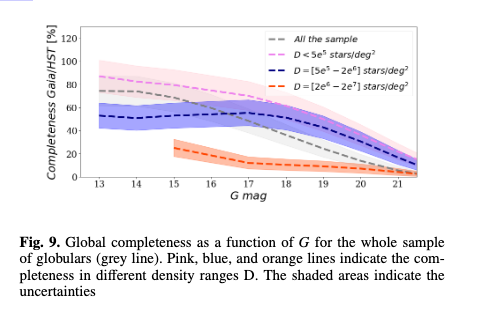

### Logistics
This notebook is intended to be runnable on `epyc.astro.washington.edu' using the Astronomy Extensions for Spark, or  [AXS](https://github.com/astronomy-commons/axs). The Gaia, PanSTARRS, and skymapper catalogs are assumed to be resident as AXS catalogs. The output is a PanSTARRS AXS catalog augmented with u band data and output phosim catalogs

In [1]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.types import StructType, StructField

### Create the Spark and AXS sessions 
Start Spark and load catalogs from AXS

In [2]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[15]")
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         .config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/jupyter/user/ctslater/proxy/4048")
         .enableHiveSupport()
         .getOrCreate())
spark_session

In [3]:
catalog = axs.AxsCatalog(spark_session)

In [4]:
#check the table exists
catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ztf_dr3_detections',
 'ps1',
 'gaia_dr2_wds_j2019',
 'gaia_dr2_wds_j2019_fall2020temp',
 'green19_stellar_params',
 'rosat_2rxs',
 'ztf_dr3',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'ztf_aug2020_combined',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_combined_z4am_b2am',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'ztf_wds_expected_kjb',
 'ztf_dr4_detections',
 'ztf_wds_kjb',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ztf_rrlyr_grid_50',
 'ps_uband',
 'ps_uband_ver2']

In [5]:
# Load Skymapper, Gaia (EDR3) and PS1 data sets 
skymapper = catalog.load("skymapper_dr2_ver3")
ps = catalog.load("ps1")
gaia = catalog.load("gaia_source_edr3")

In [6]:
print("Skymapper counts {}".format(skymapper.count()))
print("PanSTARRS counts {}".format(ps.count()))
print("Gaia counts {}".format(gaia.count()))

Skymapper counts 589364177
PanSTARRS counts 2238951222
Gaia counts 2113651513


### Measure the density of sources in the catalogs
Plot the spatial density distributions for the Gaia, PanSTARRS, and Skymapper catalogs and for a range of Galactic latitudes compare the number counts and detection limits. 

CPU times: user 13.9 s, sys: 968 ms, total: 14.9 s
Wall time: 2min


Text(0.5, 1.0, 'PanSTARRS')

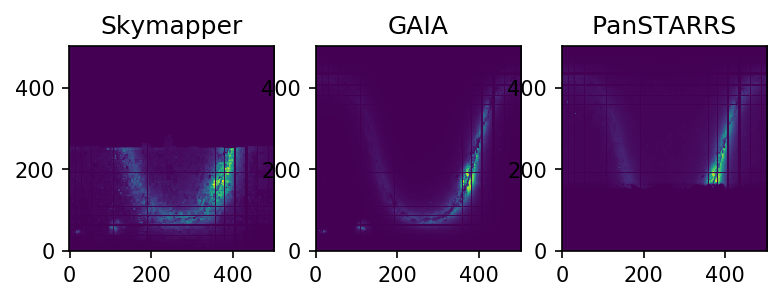

In [7]:
%%time
#plot RA, Dec density distributions 
matplotlib.rcParams['figure.dpi'] = 150
fig, axs = plt.subplots(1, 3)

results_s = skymapper.histogram2d(skymapper['ra'], skymapper['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[0].imshow(results_s[2].T, origin='lower')
axs[0].set_title("Skymapper")

result_g = gaia.histogram2d(gaia['ra'], gaia['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[1].imshow(result_g[2].T, origin='lower')
axs[1].set_title("GAIA")

result_p = ps.histogram2d(ps['ra'], ps['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[2].imshow(result_p[2].T, origin='lower')
axs[2].set_title("PanSTARRS")

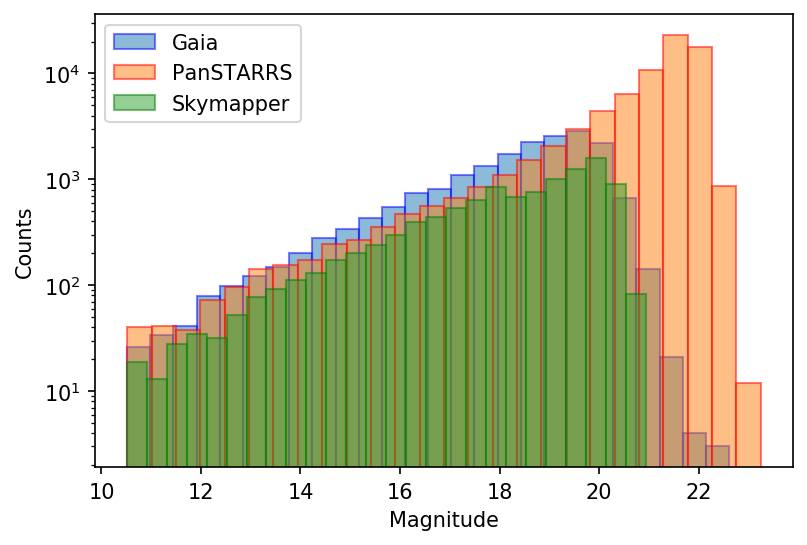

In [8]:
# compare number counts of Gaia, PS, Skymapper at high Galactic latitude
testra = 187.9869104
testdec = 0.0748496
d = 1.
nbins = 26

gaia_radec = gaia.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = gaia_radec.select('phot_rp_mean_mag').filter(gaia_radec.phot_rp_mean_mag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='blue', label='Gaia')
plt.yscale('log', nonposy='clip')
plt.xlabel("Magnitude")
plt.ylabel("Counts")

ps_radec = ps.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = ps_radec.select('rMeanPSFMag').filter(ps_radec.rMeanPSFMag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='red', label='PanSTARRS')

skymapper_radec = skymapper.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = skymapper_radec.select('r_psf').filter(skymapper_radec.r_psf.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='green', label='Skymapper')
plt.legend()

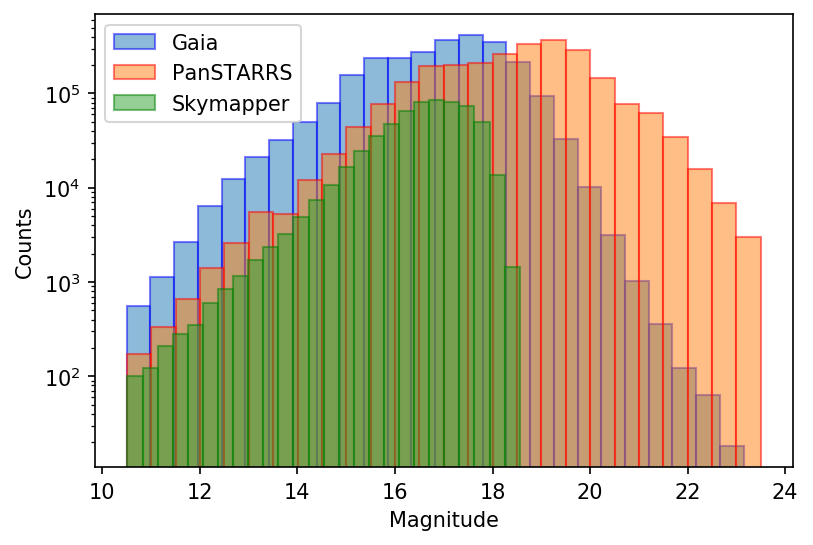

In [9]:
# compare densities of Gaia, PS, Skymapper in Baades window
testra = 270.88380338652223
testdec = -30.035274475954893
d = 1.

gaia_radec = gaia.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = gaia_radec.select('phot_rp_mean_mag').filter(gaia_radec.phot_rp_mean_mag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='blue', label='Gaia')
plt.yscale('log', nonposy='clip')
plt.xlabel("Magnitude")
plt.ylabel("Counts")

ps_radec = ps.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = ps_radec.select('rMeanPSFMag').filter(ps_radec.rMeanPSFMag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='red', label='PanSTARRS')

skymapper_radec = skymapper.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = skymapper_radec.select('r_psf').filter(skymapper_radec.r_psf.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='green', label='Skymapper')
plt.legend()


In [10]:
# calculate the dentisy of Skymapper etc at r=21.5
magMax=21.5
data_set_s = skymapper.filter(skymapper.r_psf.between(5, magMax))
data_set_g = gaia.filter(gaia.phot_rp_mean_mag.between(5, magMax))
data_set_p = ps.filter(ps.rMeanPSFMag.between(5, magMax))

results_s = data_set_s.histogram2d(data_set_s['ra'], data_set_s['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
results_g = data_set_g.histogram2d(data_set_g['ra'], data_set_g['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
results_p = data_set_p.histogram2d(data_set_p['ra'], data_set_p['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


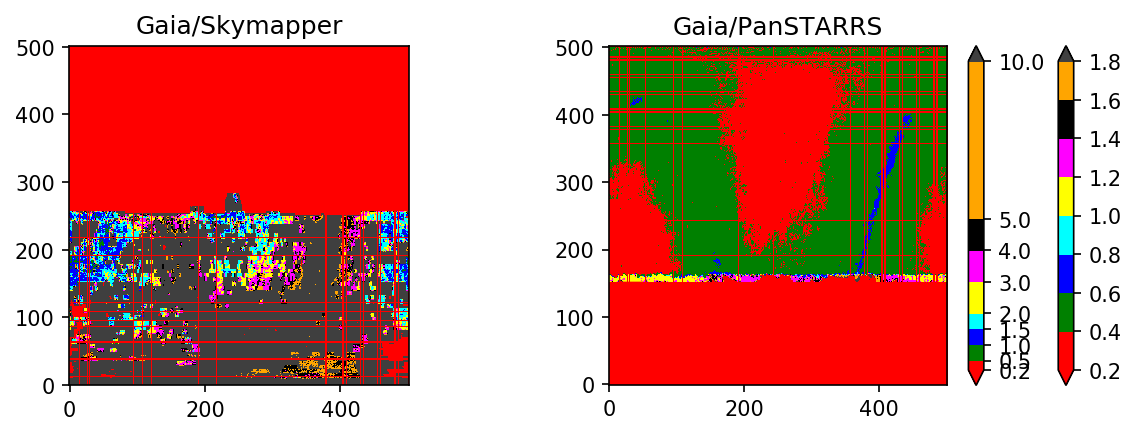

In [11]:
#plot ratios of PS/Gaia/Skymmapper source densities
import matplotlib as mpl
import matplotlib.colors as colors
def plot_ratio(dataset1, dataset2):
    ratio = dataset1[2].T / dataset2[2].T
    ratio[np.isinf(ratio)] = 0
    ratio[np.isnan(ratio)] = 0
    return ratio

fig, axs = plt.subplots( 1, 2, figsize=(10,3))
cmap_s = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan', 'yellow','magenta', 'black', 'orange'])
cmap_s.set_over('0.25')
cmap_s.set_under('0.75')
bounds_s = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
norm_s = mpl.colors.BoundaryNorm(bounds_s, cmap_s.N)

cmap_p = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan', 'yellow','magenta', 'black', 'orange'])
cmap_p.set_over('0.25')
cmap_p.set_under('0.75')
bounds_p = [0.2, 0.5, 1.0, 1.5, 2.0, 3., 4., 5., 10.]
norm_p = mpl.colors.BoundaryNorm(bounds_p, cmap_p.N)

ratio_gs = plot_ratio(results_g, results_s)
im_s = axs[0].imshow(ratio_gs, origin='lower', cmap=cmap_s, norm=norm_s, vmin=0, vmax=10., )
axs[0].set_title('Gaia/Skymapper')
fig.colorbar(im_s, cmap=cmap_s, norm=norm_s,
                                boundaries=[0] + bounds_s + [10],
                                extend='both',
                                ticks=bounds_s,
                                spacing='proportional',
                                orientation='vertical')

ratio_gp = plot_ratio(results_g, results_p)
im_p = axs[1].imshow(ratio_gp, origin='lower', cmap=cmap_p, norm=norm_p, vmin=0, vmax=10., )
axs[1].set_title('Gaia/PanSTARRS')

fig.colorbar(im_p, cmap=cmap_p, norm=norm_p,
                                boundaries=[0] + bounds_p + [20],
                                extend='both',
                                ticks=bounds_p,
                                spacing='proportional',
                                orientation='vertical')


### Derving the Rubin passbands
To output the data for a phosim image we will use an AOV star (ie zero color in AB system) and then define the magnitude for phosim in the passband of choice (e.g. u,g,r,i,z). This means we will neeed ugrizy for all GAIA stars.

Skymapper: "u_psf","g_psf","r_psf","i_psf","z_psf"

PS1: "gMeanPSFMag", "rMeanPSFMag",'iMeanPSFMag','zMeanPSFMag',"yMeanPSFMag"

For any missing passband we will derive it from the other bands using a linear relation

Assuming we use PS as the default data set we augment the PS grizy with u band data

Note that AXS matches to 1 arcsecond by default

In [12]:
ps_match_skymapper = skymapper.crossmatch(ps).select("ra","dec","axsdist","gMeanPSFMag", "rMeanPSFMag",'iMeanPSFMag','zMeanPSFMag',
                                                     "yMeanPSFMag","object_id","u_psf","g_psf","r_psf","i_psf","z_psf","iMeanKronMag")


In [13]:
ps_skymapper_pd = ps_match_skymapper.toPandas()

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Text(0, 0.5, 'iMeanPSFMag-iMeanKronMag')

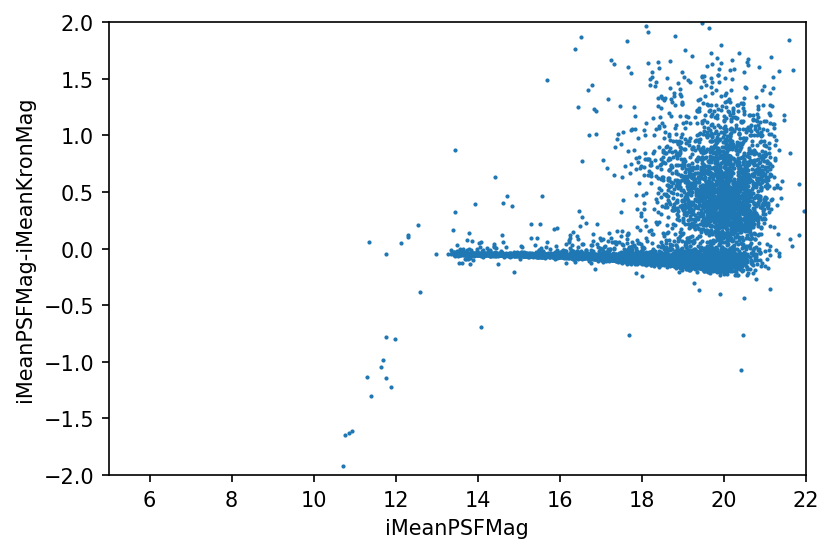

In [14]:
#create a star-galaxy separation query
# iPSFMag-iKronMag < 0.05 (stars)
fig, ax = plt.subplots()
ax.scatter(ps_skymapper_pd.iMeanPSFMag[0:10000],
           ps_skymapper_pd.iMeanPSFMag[0:10000]-ps_skymapper_pd.iMeanKronMag[0:10000],s=1)
ax.set_ylim(-2.,2.)
ax.set_xlim(5.,22.)
ax.set_xlabel("iMeanPSFMag")
ax.set_ylabel("iMeanPSFMag-iMeanKronMag")

Text(0, 0.5, 'u_psf')

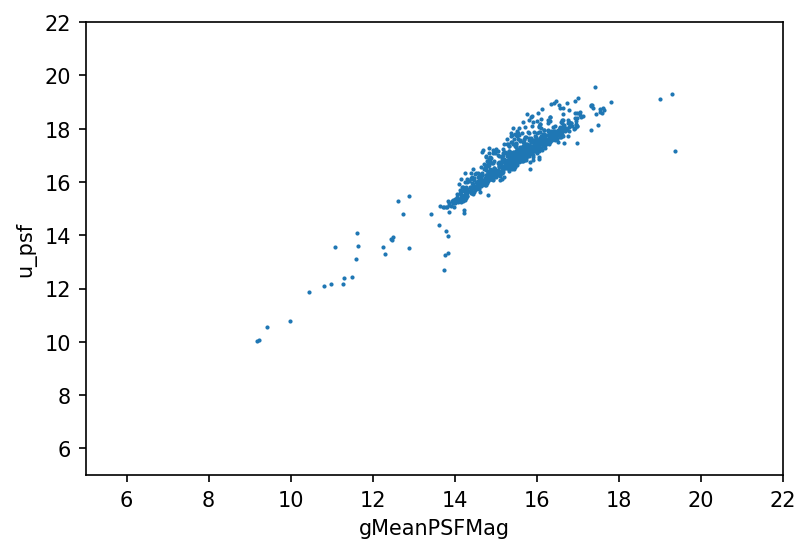

In [15]:
# Compare the ps g band vs skymapper u band
fig, ax = plt.subplots()
condition = (ps_skymapper_pd.iMeanPSFMag-ps_skymapper_pd.iMeanKronMag)<0.05
ax.scatter(ps_skymapper_pd.gMeanPSFMag[condition][0:10000], ps_skymapper_pd.u_psf[condition][0:10000],s=1)
ax.set_xlim(5.,22.)
ax.set_ylim(5.,22.)
ax.set_xlabel("gMeanPSFMag")
ax.set_ylabel("u_psf")

Text(0, 0.5, 'u_psf_predicted')

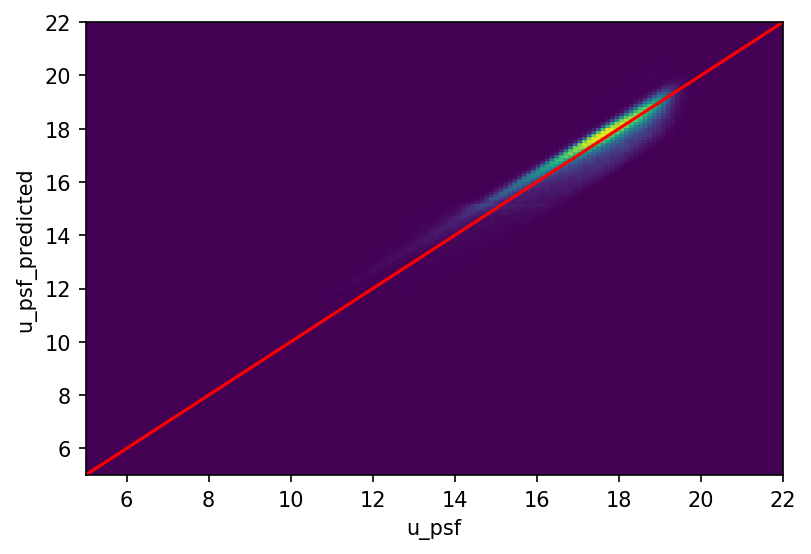

In [16]:
# model the u band from PS g r i z (fit relation to stars but apply to stars and galaxies)
# initially using g and r
# note a bad value in PS1 is given by -999
from sklearn.linear_model import LinearRegression
ps_skymapper_pd['gr'] = ps_skymapper_pd['gMeanPSFMag'] - ps_skymapper_pd['rMeanPSFMag']
ps_skymapper_pd['ri'] = ps_skymapper_pd['rMeanPSFMag'] - ps_skymapper_pd['iMeanPSFMag']
ps_skymapper_pd['iz'] = ps_skymapper_pd['iMeanPSFMag'] - ps_skymapper_pd['zMeanPSFMag']

constraintTrain =((ps_skymapper_pd['gMeanPSFMag']>5) & (ps_skymapper_pd['u_psf']>5) & 
            (ps_skymapper_pd.iMeanPSFMag-ps_skymapper_pd.iMeanKronMag < 0.05))

constraintTest =((ps_skymapper_pd['gMeanPSFMag']>5) & (ps_skymapper_pd['u_psf']>5))

#X_train = ps_skymapper_pd[['gMeanPSFMag','gr','ri','iz']][constraintTrain].values
X_train = ps_skymapper_pd[['gMeanPSFMag','gr',]][constraintTrain].values
Y_train = ps_skymapper_pd['u_psf'][constraintTrain].values

#X_test = ps_skymapper_pd[['gMeanPSFMag','gr','ri','iz']][constraintTest].values
X_test = ps_skymapper_pd[['gMeanPSFMag','gr',]][constraintTest].values
Y_test = ps_skymapper_pd['u_psf'][constraintTest].values

#using scikit-learn
lr = LinearRegression()
lr.fit(X_train, Y_train)  
y_fit = lr.predict(X_test)

fig, ax = plt.subplots()
ax.hexbin(Y_test, y_fit, gridsize=(150,150) ,extent=[5,22,5,22])
plt.plot([5.,22.],[5.,22.],color='red')
ax.set_xlabel("u_psf")
ax.set_ylabel("u_psf_predicted")

In [17]:
# add "u band" synthetic data to PS and save as augmented Spark catalog.
#from pyspark.sql.functions import when
#ps = ps.withColumn("uMeanPSFMag",
#                               when((ps["rMeanPSFMag"] < -900) | (ps["gMeanPSFMag"] < -900), -999).otherwise(
#                               lr.intercept_ + lr.coef_[0]*ps["gMeanPSFMag"] + lr.coef_[1]*(ps["gMeanPSFMag"] - ps["rMeanPSFMag"])
#                               + lr.coef_[2]*(ps["rMeanPSFMag"] - ps["iMeanPSFMag"])
#                               + lr.coef_[3]*(ps["iMeanPSFMag"] - ps["zMeanPSFMag"])))

In [18]:
from pyspark.sql.functions import when
ps = ps.withColumn("uMeanPSFMag",
                               when((ps["rMeanPSFMag"] < -900) | (ps["gMeanPSFMag"] < -900), -999).otherwise(
                               lr.intercept_ + lr.coef_[0]*ps["gMeanPSFMag"] + lr.coef_[1]*(ps["gMeanPSFMag"] - ps["rMeanPSFMag"])
                               ))

In [19]:
import os
from collections import OrderedDict
passbands = {"u":"uMeanPSFMag", "g":"gMeanPSFMag", "r":"rMeanPSFMag", 
             "i":"iMeanPSFMag", "z":"zMeanPSFMag", "y":"yMeanPSFMag", }

def writePhosimHeader(output, ra, dec, camconfig=3, Opsim_filter=3, mjd=59580.):
    '''Write to file handle the phosim header'''
    output.write("Opsim_obshistid {}\n".format(9006002))
    output.write("Opsim_filter {}\n".format(Opsim_filter))
    output.write("mjd {}\n".format(mjd))
    output.write("SIM_SEED {}\n".format(1000))
    output.write("rightascension {}\n".format(ra))
    output.write("declination {}\n".format(dec))
    output.write("rotskypos {}\n".format(0.000000))
    output.write("rottelpos {}\n".format(0))
    output.write("SIM_VISTIME {}\n".format(0.25))
    output.write("SIM_NSNAP {}\n".format(1))
    output.write("moonphase {}\n".format(0.0))
    output.write("moonalt {}\n".format(-90))
    output.write("sunalt {}\n".format(-90))
    output.write("Opsim_rawseeing {}\n".format(-1))
    output.write("camconfig {}\n".format(camconfig))

def writePhosimCatalog(catalog, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir="./", camconfig=3):
    '''Generate a phosim instance catalog from a Spark AXS catalog'''
    outFile = os.path.join(outDir, phosimFile)
    phosimCat = catalog.region(ra1=ra-radius, ra2=ra+radius, dec1=dec-radius, dec2=dec+radius)

    #select columns and convert to pandas to output a single file
    psCat = phosimCat.select("objID","ra","dec", passbands[passband]).filter("{} > -900".format(passbands[passband])).toPandas()

    #filter catalog
    filterID = list(passbands.keys()).index(passband)
    with open(outFile,'w') as output:
        writePhosimHeader(output, ra, dec, camconfig=camconfig, Opsim_filter=filterID, mjd=59580.)
        for index, row in psCat.iterrows():
            output.write("object {} {} {} ../sky/sed_flat.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 12.0 none none\n".format(
                int(row["objID"]),row["ra"],row["dec"]))

In [20]:
ra = 287.9869104
dec = -30.0748496
radius = 0.1
path = '/astro/users/ajc26/epycuser/LSST-Commissioning/aos/phosim_cats'
writePhosimCatalog(ps, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir=path)

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [21]:
%%time
#save ps as a new axs file
#catalog.save_axs_table(ps, "ps_uband_ver2")

CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 37 µs


In [22]:
# read and output a catalog
#psPhosim = catalog.load("ps_uband_ver2")